## WILKS 2005

**Effects of stochastic parametrizations in the Lorenz'96 system**

### Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
from sklearn.linear_model import LinearRegression
from numba import jit
from sklearn.metrics import r2_score

### LORENZ 96 THRUTH

In [2]:
@jit(nopython=True)
def L96_eq(X,Y,h,b,c,F):
    K = X.size
    J = Y.size//K
    dXdt = np.zeros(X.shape)
    dYdt = np.zeros(Y.shape)
    for k in range(K):
        dXdt[k] = -X[(k-1)%K]*(X[(k-2)%K] - X[(k+1)%K]) - X[k] + F - (h*c/b)*np.sum(Y[k*J:(k+1)*J])
    for j in range(J*K):
        dYdt[j] = -c*b*Y[(j+1)%(K*J)]*(Y[(j+2)%(K*J)] - Y[(j-1)%(K*J)]) - c*Y[j] + (h*c/b)*X[j//J]
            
    return dXdt, dYdt
#checked

In [3]:
@jit(nopython=True)
def L96_model(X,h,b,c,F, B):
    K = X.size
    dXdt = np.zeros(X.shape)
    [b0,b1,b2,b3,b4] = B
    for k in range(K):
        gU = b0 + b1*X[k] + b2*X[k]**2 + b3*X[k]**3 + b4*X[k]**4
        dXdt[k] = -X[(k-1)%K]*(X[(k-2)%K] - X[(k+1)%K]) - X[k] + F - gU
            
    return dXdt

In [4]:
#sd standard deviation
@jit(nopython=True)
def L96_stochastic_model(X,h,b,c,F, B, phi, sd):
    K = X.size
    dXdt = np.zeros(X.shape)
    [b0,b1,b2,b3,b4] = B
    ek_prev = np.zeros(K)
    for k in range(K):
        
        zk = np.random.randn(K)
        
        ek_cur = phi*ek_prev + sd*np.sqrt(1-phi**2)*zk
        gU = b0 + b1*X[k] + b2*X[k]**2 + b3*X[k]**3 + b4*X[k]**4 + ek_cur[k]
        dXdt[k] = -X[(k-1)%K]*(X[(k-2)%K] - X[(k+1)%K]) - X[k] + F - gU
        ek_prev = ek_cur
            
    return dXdt

### RUNGEKUTTA

In [5]:
@jit(nopython=True)
def Rk4(x_n,y_n,ts,h,b,c,F):
    K1x, K1y = L96_eq(x_n,y_n,h,b,c,F)
    K2x, K2y = L96_eq(x_n + K1x*ts/2, y_n + K1y*ts/2,h,b,c,F)
    K3x, K3y = L96_eq(x_n + K2x*ts/2, y_n + K2y*ts/2,h,b,c,F)
    K4x, K4y = L96_eq(x_n + K3x*ts, y_n + K3y*ts,h,b,c,F)

    x_np1 = x_n + ts*(K1x + 2*K2x + 2*K3x + K4x)/6
    y_np1 = y_n + ts*(K1y + 2*K2y + 2*K3y + K4y)/6
        
    return x_np1, y_np1

In [6]:
@jit(nopython=True)
def Rk2(x_n,ts_model,h,b,c,F, B):
    K1 = L96_model(x_n,h,b,c,F, B)
    K2 = L96_model(x_n + K1*ts_model/2,h,b,c,F, B)

    x_np1 = x_n + ts_model*K2
        
    return x_np1

In [7]:
@jit(nopython=True)
def Rk4_stochastic_model(x_n,ts,h,b,c,F, B, phi, sd):
    K1x = L96_stochastic_model(x_n,h,b,c,F, B, phi, sd)
    K2x = L96_stochastic_model(x_n + K1x*ts/2,h,b,c,F, B, phi, sd)
    K3x = L96_stochastic_model(x_n + K2x*ts/2,h,b,c,F, B, phi, sd)
    K4x = L96_stochastic_model(x_n + K3x*ts,h,b,c,F, B, phi, sd)

    x_np1 = x_n + ts*(K1x + 2*K2x + 2*K3x + K4x)/6
        
    return x_np1

In [8]:
@jit(nopython=True)
def Rk2_stochastic_model(x_n,ts_model,h,b,c,F, B, phi, sd):
    K1 = L96_stochastic_model(x_n,h,b,c,F, B, phi, sd)
    K2 = L96_stochastic_model(x_n + K1*ts_model/2,h,b,c,F, B, phi, sd)

    x_np1 = x_n + ts_model*K2
        
    return x_np1

In [9]:
T = 1100000000 #No of timesteps
K = 8
J = 32
F = 18
h = 1
c = 10
b = 10
ts = 0.0001
ts_model = 0.005

### Integrating the model

In [10]:
@jit
def L96_integrate(T,K,J,ts,h,b,c,F):
    X_arr = np.zeros([T//50, K])
    
    print('alloted memory for X_arr')

    np.random.seed(0)
    X_in = np.random.random(K)
    Y_in = np.random.random(J*K)*0.1

    for j in range(T):
        X_out, Y_out = Rk4(X_in,Y_in,ts,h,b,c,F)
        X_in = X_out
        Y_in = Y_out
    
#         if j%50 == 0:
#             X_arr[j//50,:] = X_in
#             if j%1000000 == 0:
#                 print(j//1000000)
    return X_arr

In [11]:
@jit
def L96_integrate_model(T,K,ts_model,h,b,c,F,B):
    X_arr_model = np.zeros([T//50, K])
    
    print('alloted memory for X_arr_model')

    np.random.seed(0)
    X_in = np.random.random(K)

    for j in range(T//50):
        X_out = Rk2(X_in,ts_model,h,b,c,F, B)
        X_in = X_out      
        X_arr_model[j,:] = X_in
#         if j%1000000 == 0:
#             print(j//1000000)

    return X_arr_model

In [12]:
@jit
def L96_integrate_stochastic_model(T,K,ts_model,h,b,c,F,B, phi, sd):
    X_arr_model = np.zeros([T//50, K])
    
    print('alloted memory for X_arr_model')

    np.random.seed(0)
    X_in = np.random.random(K)

    for j in range(T//50):
        X_out = Rk2_stochastic_model(X_in,ts_model,h,b,c,F, B, phi, sd)
        X_in = X_out      
        X_arr_model[j,:] = X_in
#         if j%1000000 == 0:
#             print(j//1000000)

    return X_arr_model

In [13]:
@jit
def L96_Rk4_integrate_stochastic_model(T,K,ts_model,h,b,c,F,B, phi, sd):
    X_arr_model = np.zeros([T//50, K])
    
    print('alloted memory for X_arr_model')

    np.random.seed(0)
    X_in = np.random.random(K)

    for j in range(T//50):
        X_out = Rk4_stochastic_model(X_in,ts_model,h,b,c,F, B, phi, sd)
        X_in = X_out      
        X_arr_model[j,:] = X_in
#         if j%1000000 == 0:
#             print(j//1000000)

    return X_arr_model

In [14]:
## X_arr = L96_integrate(T,K,J,ts,h,b,c,F)

In [11]:
## np.savez('X_truth.npz', X_arr = X_arr)

**500 time steps/sec**

### U(t) calculation

In [15]:
with np.load("X_truth.npz") as data:
    X_arr = data['X_arr']

In [90]:
s_square = np.sum(X_arr**2, axis = 1, keepdims = True)/K
s_square.shape

(22000000, 1)

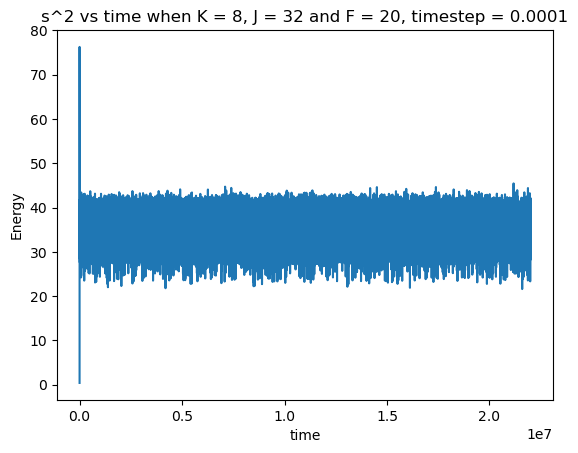

In [16]:
plt.plot(range(len(s_square)), s_square)
plt.xlabel('time')
plt.ylabel('Energy')
#plt.ylim(4,14)
plt.title('s^2 vs time when K = 8, J = 32 and F = 20, timestep = 0.0001')
#plt.savefig('Regime_K8_J32_F20.png')
plt.show()

In [16]:
U = np.zeros([2200,K])
X_fit = np.zeros([2200,K])
for k in range(K):
    for t in range(2200):
        j = t*10000
        X_fit[t,:] = X_arr[j,:]
        U[t,k] = -X_arr[j,(k-1)%K]*(X_arr[j,(k-2)%K] - X_arr[j,(k+1)%K]) - X_arr[j,k] + F - (X_arr[j+1,k] - X_arr[j,k])/ts_model

Text(0, 0.5, 'Unresolved tendency U(t)')

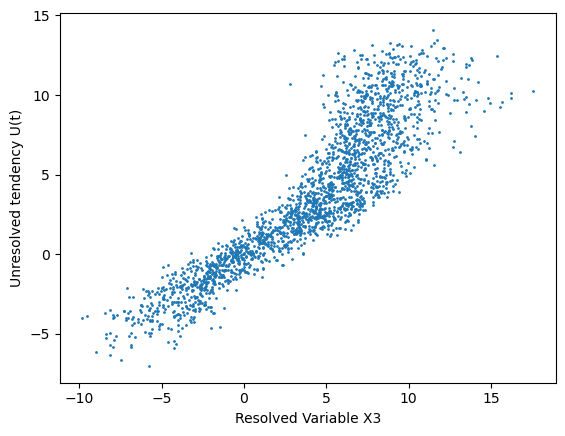

In [17]:
plt.scatter(U[:,3], X_fit[:,3], 1)
plt.xlabel('Resolved Variable X3')
plt.ylabel('Unresolved tendency U(t)')
#plt.savefig('U_vs_X3.png')

### Polynomial fit

In [18]:
m = 0
n = 2200
k = 3
X_train = np.zeros([n - m, 4])
X_train[:,0] = X_fit[m:n,k]
X_train[:,1] = X_fit[m:n,k]**2
X_train[:,2] = X_fit[m:n,k]**3
X_train[:,3] = X_fit[m:n,k]**4

Y_train = U[m:n,k]

In [19]:
reg = LinearRegression()
reg.fit(X_train, Y_train)

LinearRegression()

In [20]:
reg.coef_, reg.intercept_

(array([ 1.58561490e+00, -1.74721775e-02, -1.26824108e-02,  7.06495606e-04]),
 0.2478317490335633)

In [21]:
Y_pred = reg.predict(X_train)
R2 = r2_score(Y_train, reg.predict(X_train))
R2

0.8771757485802908

In [22]:
b0 = reg.intercept_
[b1, b2, b3, b4] = reg.coef_
B = [b0, b1, b2, b3, b4]

In [23]:
myu = b0 + b1*X_train[:,0] + b2*X_train[:,1] + b3*X_train[:,2]+ b4*X_train[:,3]
sd = np.sqrt((np.sum((Y_train - myu)**2))/len(Y_train))
sd

1.6806379239237272

In [24]:
X3 = np.linspace(-6, 15, 5000)
Y3 = b0 + b1*X3 + b2*X3**2 + b3*X3**3 + b4*X3**4

In [25]:
Y3

array([-6.23983704, -6.24060707, -6.2413643 , ..., 13.04691796,
       13.05546209, 13.06401911])

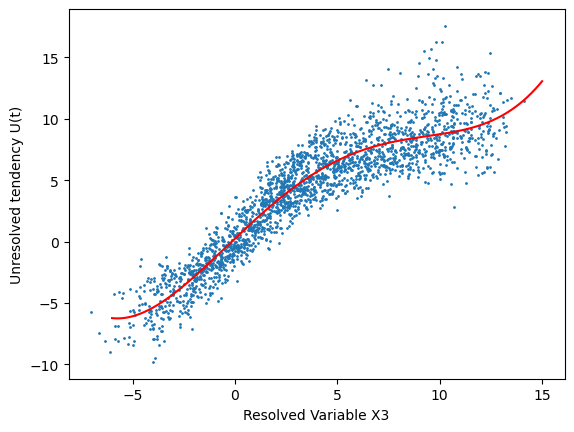

In [26]:
plt.scatter(X_fit[:,3],U[:,3], 1)
plt.plot(X3, Y3,0.5, c = 'red')
plt.xlabel('Resolved Variable X3')
plt.ylabel('Unresolved tendency U(t)')
plt.savefig('U_vs_X3.png')

**For F = 20**

0.262 1.45 −0.0121 −0.00713 0.000296 1.99 86.3%

array([ 0.00000000e+00,  1.45296091e+00, -2.21181770e-02, -6.32664016e-03,
        2.96796387e-04])

### Integrating the equation using Rk2

In [27]:
X_arr_model = L96_integrate_model(T,K,ts_model,h,b,c,F, B)

C:\Users\abhil\AppData\Local\Temp\ipykernel_7304\869679993.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "L96_integrate_model" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'ol_np_zeros': File: numba\np\arrayobj.py: Line 4164.
    With argument(s): '(list(int64)<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<built-in function empty>) found for signature:
    
    >>> empty(list(int64)<iv=None>, dtype=Function(<class 'float'>))
    
   There are 2 candidate implementations:
         - Of which 2 did not match due to:
         Overload in function 'ol_np_empty': File: numba\np\arrayob

alloted memory for X_arr_model


D:\SOFTWARES\Anaconda\Anaconda1\lib\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'B' of function 'L96_integrate_model'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\..\..\AppData\Local\Temp\ipykernel_7304\869679993.py", line 10:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [28]:
X_model_hist,bins = np.histogram(X_arr_model[:,3],bins = np.linspace(-10,15,5000))

In [29]:
np.max(X_model_hist)

9747

In [30]:
np.sum(X_model_hist)

22000000

(0.0, 10000.0)

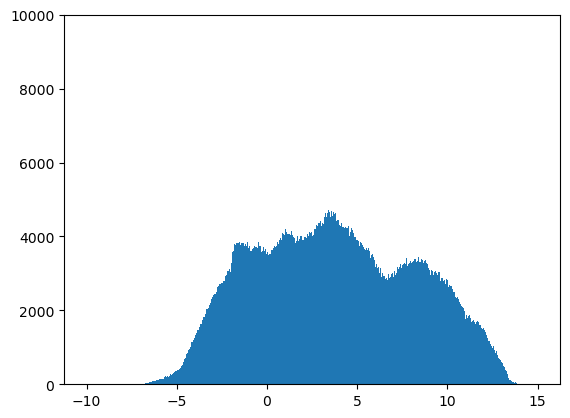

In [31]:
plt.hist(X_arr_model[:,2],bins = np.linspace(-10,15,10000))
plt.ylim(0, 10000)

In [59]:
X_arr_hist, bins = np.histogram(X_arr[:,3],bins = np.linspace(-10,15,5000))

In [60]:
np.max(X_arr_hist)

9435

In [61]:
np.sum(X_arr_hist)

22000000

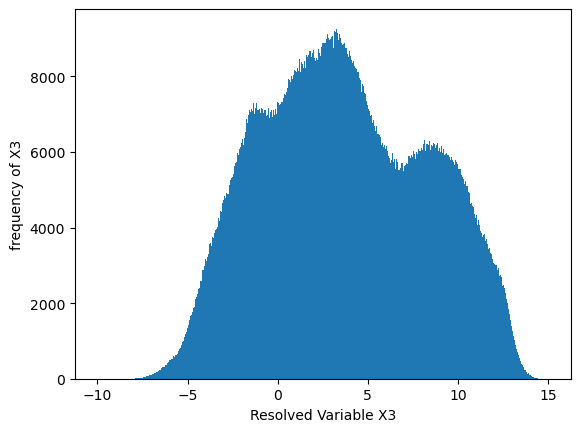

In [68]:
plt.hist(X_arr[:,0],bins = np.linspace(-10,15,5000))
plt.xlabel('Resolved Variable X3')
plt.ylabel('frequency of X3')
plt.savefig('frequency_X_truth.png')

### GIVEN IN PAPER

In [102]:
B1 = [0.275, 1.59, -0.0190, -0.0130, 0.000707]
X_arr_model_paper = L96_integrate_model(T,K,ts_model,h,b,c,F, B1)

C:\Users\abhil\AppData\Local\Temp\ipykernel_5804\869679993.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "L96_integrate_model" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'ol_np_zeros': File: numba\np\arrayobj.py: Line 4164.
    With argument(s): '(list(int64)<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<built-in function empty>) found for signature:
    
    >>> empty(list(int64)<iv=None>, dtype=Function(<class 'float'>))
    
   There are 2 candidate implementations:
         - Of which 2 did not match due to:
         Overload in function 'ol_np_empty': File: numba\np\arrayob

alloted memory for X_arr_model


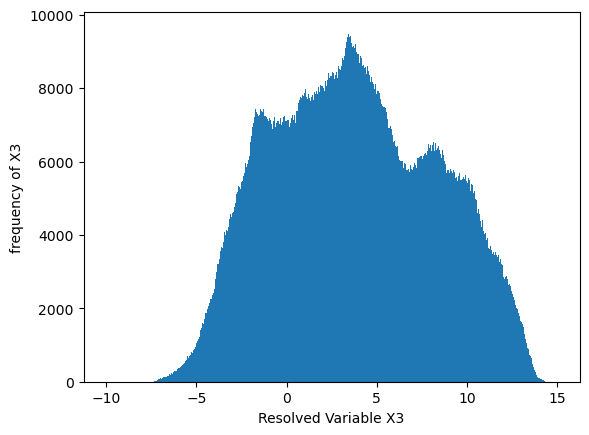

In [103]:
plt.hist(X_arr_model_paper[:,0],bins = np.linspace(-10,15,5000))
plt.xlabel('Resolved Variable X3')
plt.ylabel('frequency of X3')
plt.savefig('frequency_X_truth_paper.png')

### DETERMINISTIC $\phi$ = $\sigma_e$ = 0

In [104]:
X_determistic = L96_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, 0, 0)

C:\Users\abhil\AppData\Local\Temp\ipykernel_5804\2099268280.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "L96_integrate_stochastic_model" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'ol_np_zeros': File: numba\np\arrayobj.py: Line 4164.
      With argument(s): '(list(int64)<iv=None>)':
     Rejected as the implementation raised a specific error:
       TypingError: Failed in nopython mode pipeline (step: nopython frontend)
     No implementation of function Function(<built-in function empty>) found for signature:
      
      >>> empty(list(int64)<iv=None>, dtype=Function(<class 'float'>))
      
     There are 2 candidate implementations:
           - Of which 2 did not match due to:
           Overload in function '

alloted memory for X_arr_model


In [105]:
X_white = L96_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, 0, sd)

C:\Users\abhil\AppData\Local\Temp\ipykernel_5804\2099268280.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "L96_integrate_stochastic_model" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'ol_np_zeros': File: numba\np\arrayobj.py: Line 4164.
        With argument(s): '(list(int64)<iv=None>)':
       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       No implementation of function Function(<built-in function empty>) found for signature:
        
        >>> empty(list(int64)<iv=None>, dtype=Function(<class 'float'>))
        
       There are 2 candidate implementations:
             - Of which 2 did not match due to:
           

alloted memory for X_arr_model


D:\SOFTWARES\Anaconda\Anaconda1\lib\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'B' of function 'L96_integrate_stochastic_model'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\..\..\AppData\Local\Temp\ipykernel_5804\2099268280.py", line 10:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [106]:
#choosen such that correlation timescale = 64 model time steps
phi = np.exp(-1/(64))
phi

0.9844964370054085

In [107]:
X_red = L96_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, phi, sd)

C:\Users\abhil\AppData\Local\Temp\ipykernel_5804\2099268280.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "L96_integrate_stochastic_model" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'ol_np_zeros': File: numba\np\arrayobj.py: Line 4164.
        With argument(s): '(list(int64)<iv=None>)':
       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       No implementation of function Function(<built-in function empty>) found for signature:
        
        >>> empty(list(int64)<iv=None>, dtype=Function(<class 'float'>))
        
       There are 2 candidate implementations:
             - Of which 2 did not match due to:
           

alloted memory for X_arr_model


In [ ]:
L96_Rk4_integrate_stochastic_model

In [42]:
X_determistic1 = L96_Rk4_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, 0, 0)

C:\Users\abhil\AppData\Local\Temp\ipykernel_13720\2133115902.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "L96_Rk4_integrate_stochastic_model" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'ol_np_zeros': File: numba\np\arrayobj.py: Line 4164.
        With argument(s): '(list(int64)<iv=None>)':
       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       No implementation of function Function(<built-in function empty>) found for signature:
        
        >>> empty(list(int64)<iv=None>, dtype=Function(<class 'float'>))
        
       There are 2 candidate implementations:
             - Of which 2 did not match due to:
      

alloted memory for X_arr_model


D:\SOFTWARES\Anaconda\Anaconda1\lib\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'B' of function 'L96_Rk4_integrate_stochastic_model'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\..\..\AppData\Local\Temp\ipykernel_13720\2133115902.py", line 10:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [43]:
X_white1 = L96_Rk4_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, 0, sd)

C:\Users\abhil\AppData\Local\Temp\ipykernel_13720\2133115902.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "L96_Rk4_integrate_stochastic_model" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'ol_np_zeros': File: numba\np\arrayobj.py: Line 4164.
        With argument(s): '(list(int64)<iv=None>)':
       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       No implementation of function Function(<built-in function empty>) found for signature:
        
        >>> empty(list(int64)<iv=None>, dtype=Function(<class 'float'>))
        
       There are 2 candidate implementations:
             - Of which 2 did not match due to:
      

alloted memory for X_arr_model


In [44]:
X_red1 = L96_Rk4_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, phi, sd)

C:\Users\abhil\AppData\Local\Temp\ipykernel_13720\2133115902.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "L96_Rk4_integrate_stochastic_model" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'ol_np_zeros': File: numba\np\arrayobj.py: Line 4164.
        With argument(s): '(list(int64)<iv=None>)':
       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       No implementation of function Function(<built-in function empty>) found for signature:
        
        >>> empty(list(int64)<iv=None>, dtype=Function(<class 'float'>))
        
       There are 2 candidate implementations:
             - Of which 2 did not match due to:
      

alloted memory for X_arr_model


In [ ]:
L96_integrate_stochastic_model(T,K,ts_model,h,b,c,F,B, phi, sd)

In [ ]:
L96_integrate_stochastic_model(T,K,ts_model,h,b,c,F,B, 0, 0)

In [30]:
X_d = L96_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, 0, 0)

C:\Users\abhil\AppData\Local\Temp\ipykernel_7304\2099268280.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "L96_integrate_stochastic_model" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'ol_np_zeros': File: numba\np\arrayobj.py: Line 4164.
      With argument(s): '(list(int64)<iv=None>)':
     Rejected as the implementation raised a specific error:
       TypingError: Failed in nopython mode pipeline (step: nopython frontend)
     No implementation of function Function(<built-in function empty>) found for signature:
      
      >>> empty(list(int64)<iv=None>, dtype=Function(<class 'float'>))
      
     There are 2 candidate implementations:
           - Of which 2 did not match due to:
           Overload in function '

alloted memory for X_arr_model


In [32]:
X_r = L96_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, 0.9845, sd)

C:\Users\abhil\AppData\Local\Temp\ipykernel_7304\2099268280.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "L96_integrate_stochastic_model" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'ol_np_zeros': File: numba\np\arrayobj.py: Line 4164.
        With argument(s): '(list(int64)<iv=None>)':
       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       No implementation of function Function(<built-in function empty>) found for signature:
        
        >>> empty(list(int64)<iv=None>, dtype=Function(<class 'float'>))
        
       There are 2 candidate implementations:
             - Of which 2 did not match due to:
           

alloted memory for X_arr_model


In [37]:
X_r1 = L96_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, 0.9845*1.5, sd)

alloted memory for X_arr_model


In [40]:
X_r2 = L96_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, 0.75, sd)

alloted memory for X_arr_model


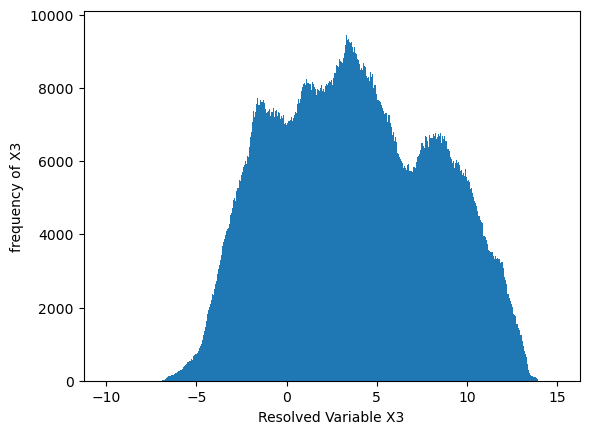

In [108]:
plt.hist(X_determistic[:,0],bins = np.linspace(-10,15,5000))
plt.xlabel('Resolved Variable X3')
plt.ylabel('frequency of X3')
plt.savefig('frequency_X_deterministic.png')

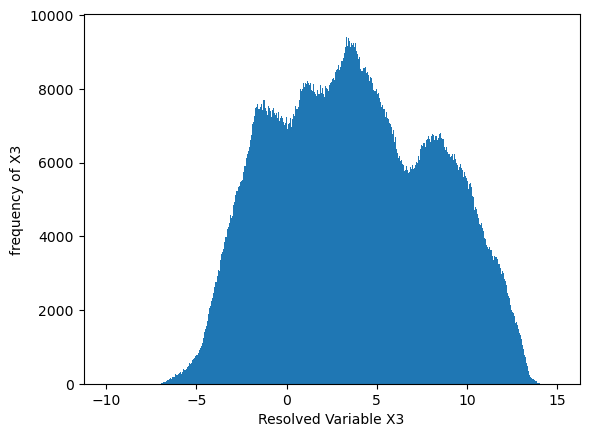

In [109]:
plt.hist(X_white[:,0],bins = np.linspace(-10,15,5000))
plt.xlabel('Resolved Variable X3')
plt.ylabel('frequency of X3')
plt.savefig('frequency_X_white.png')

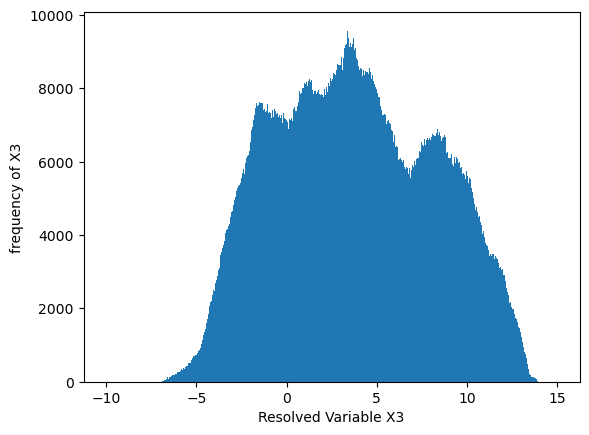

In [110]:
plt.hist(X_red[:,0],bins = np.linspace(-10,15,5000))
plt.xlabel('Resolved Variable X3')
plt.ylabel('frequency of X3')
plt.savefig('frequency_X_red.png')

### Dn Statistics

In [33]:
def Dn(X_model, X_truth, b_low, b_up, num_of_bars):
    
    width = (b_up - b_low)/num_of_bars
    
    X_truth_hist, bins = np.histogram(X_truth,bins = np.linspace(b_low,b_up,num_of_bars))
    X_model_hist, bins = np.histogram(X_model,bins = np.linspace(b_low,b_up,num_of_bars))
    
    
    maxi = 0
    Area_truth = 0
    Area_model = 0
    for i in range(len(X_truth_hist)-1):
        Area_truth += width*X_truth_hist[i]
        Area_model += width*X_model_hist[i]
        maxi = max(maxi, abs(Area_truth - Area_model))
        
    return maxi/(len(X_truth)*width)

In [34]:
b_low, b_up, num_of_bars = -15,20,500000
width = (b_up - b_low)/num_of_bars

In [47]:
Dn_deter = Dn(X_determistic[:,0], X_arr[:,0], b_low, b_up, num_of_bars)

In [48]:
Dn_white = Dn(X_white[:,0], X_arr[:,0], b_low, b_up, num_of_bars)

In [49]:
Dn_red = Dn(X_red[:,3], X_arr[:,3], b_low, b_up, num_of_bars)

In [50]:
Dn_deter, Dn_white, Dn_red

(0.014460227272735587, 0.014865909090920252, 0.0150260000000127)

In [51]:
Dn_deter1 = Dn(X_determistic1[:,0], X_arr[:,0], b_low, b_up, num_of_bars)
Dn_white1 = Dn(X_white1[:,0], X_arr[:,0], b_low, b_up, num_of_bars)
Dn_red1 = Dn(X_red1[:,3], X_arr[:,3], b_low, b_up, num_of_bars)

In [52]:
Dn_deter1, Dn_white1, Dn_red1

(0.01470009090909373, 0.01473318181819027, 0.014711136363652786)

In [35]:
Dn_d = Dn(X_d[:,0], X_arr[:,0], b_low, b_up, num_of_bars)
Dn_r = Dn(X_r[:,0], X_arr[:,0], b_low, b_up, num_of_bars)

In [43]:
Dn_d, Dn_r, Dn_r1, Dn_r2

(0.014460227272735587,
 0.014177681818197747,
 1.0000000000006766,
 0.014558000000017479)

In [38]:
Dn_r1 = Dn(X_r1[:,0], X_arr[:,0], b_low, b_up, num_of_bars)

In [41]:
Dn_r2 = Dn(X_r2[:,0], X_arr[:,0], b_low, b_up, num_of_bars)

In [53]:
Dn_deter_using_integral = Dn(X_arr_model[:,0], X_arr[:,0], b_low, b_up, num_of_bars)

In [54]:
Dn_deter_using_integral

0.014460227272735587

In [56]:
X_red2 = L96_Rk4_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, phi*1.1, sd*1.5)

alloted memory for X_arr_model


KeyboardInterrupt: 

In [ ]:
num_pts1 = 30
num_pts2 = 20
phi_arr = np.linspace(0,1, num_pts1)
sd_arr = np.linspace(0,2.5*sd, num_pts2)
for i in range(num_pts1):
    for j in range(num_pts2):
        phi = phi_arr[i]
        sd = sd_arr[j]
        X_red = L96_integrate_stochastic_model(T, K, ts_model, h, b, c, F, B, phi, sd)
        file1 = 'X_arr_red.npz'
        file2 = 'X_arr_phi_sd.npz'
        var1 = 'X_red' +'_'+ str(i)+ '_'+ str(j)
        var2 = 'X_red' +'_'+ str(phi)+ '_'+ str(sd)
        var_name1 = globals()[var1]
        var_name2 = globals()[var2]
        np.savez(file1, var_name1 = X_red)
        np.savez(file2, var_name2 = X_red)
        
    print(i)

## REGRESSION ANALYSIS

In [67]:
m = 0
n = 2200
k = 3

X_train = np.zeros([n - m, 4])
X_train[:,0] = X_fit[m:n,k]
X_train[:,1] = X_fit[m:n,k]**2
X_train[:,2] = X_fit[m:n,k]**3
X_train[:,3] = X_fit[m:n,k]**4

Y_train = U[m:n,k]

In [68]:
reg1 = LinearRegression()
reg1.fit(X_train, Y_train)

LinearRegression()

In [69]:
#k = 7
reg1.intercept_, reg1.coef_

(0.2478317490335633,
 array([ 1.58561490e+00, -1.74721775e-02, -1.26824108e-02,  7.06495606e-04]))

In [88]:
#k = 6
reg1.intercept_, reg1.coef_

(0.2783522949332822,
 array([ 1.54818556e+00, -2.02077511e-02, -1.03317939e-02,  5.34024747e-04]))

In [85]:
#k = 5
reg1.intercept_, reg1.coef_

(0.2987976317523513,
 array([ 1.54494312e+00, -1.86704126e-02, -1.04969917e-02,  5.46334323e-04]))

In [82]:
#k = 4
reg1.intercept_, reg1.coef_

(0.26514691950612423,
 array([ 1.55709797e+00, -1.59446112e-02, -1.12835613e-02,  5.94231559e-04]))

In [94]:
#k = 3
reg1.intercept_, reg1.coef_

(0.2478317490335633,
 array([ 1.58561490e+00, -1.74721775e-02, -1.26824108e-02,  7.06495606e-04]))

In [79]:
k = 2
reg1.intercept_, reg1.coef_

(0.2614239633210942,
 array([ 1.56351772e+00, -1.56042646e-02, -1.19061487e-02,  6.36352595e-04]))

In [66]:
#k = 1
reg1.intercept_, reg1.coef_

(0.2937348737052159,
 array([ 1.54517240e+00, -2.20766815e-02, -1.00492610e-02,  5.30374299e-04]))

In [40]:
np.sum(X_fit[m:n,:], axis = 1, keepdims=True).shape

(2200, 1)